In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
import healpy as hp
import pysm 
from pysm.nominal import models
from pysm.common import convert_units
import camb
from camb import model, initialpower

In [22]:
nside = 1024; lmax = 2500

In [10]:
# power_law in uK_RJ, not uK_CMB

f1 = convert_units('uK_RJ','uK_CMB', 100)
f2 = convert_units('K_CMB','uK_RJ', 100); f4 = convert_units('K_CMB','uK_RJ', 353)
f3 = convert_units('uK_RJ', 'uK_CMB', 100)

In [5]:
ali_ma = hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits', verbose=False)
def Mask(maps): 
    maps_ma = hp.ma(maps)
    maps_ma.mask = np.logical_not(ali_ma)
    return maps_ma

In [11]:
# unit of CMB: uk_CMB; unit of noise: uK_CMB
cmb = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/cmb_maps_camb.fits', verbose=False, field=None), nside_out = 1024)
# noise_ali = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/noise_realizations1.fits',field = None, verbose=False), nside_out = 1024)
# noise_ali_ma = Mask(noise_ali)

# noise_150 = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/noise_realizations_150.fits',field = None, verbose=False), nside_out = 1024)
# noise_150_ma = Mask(noise_150)

# # Q, U, spectra index
# # uK_RJ
# dust_real = hp.ud_grade(hp.read_map('/home/jianyao/Ali_maps/COM_CompMap_QU-thermaldust-commander_2048_R3.00_full.fits', verbose=False, field = None), nside_out = 1024)

# I Q U
# K_CMB
dust_353 = f4*hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/COM_SimMap_thermaldust-ffp10-skyinbands-353_2048_R3.00_full.fits', verbose=False, field = None), nside_out = 1024)
dust_100 = 1e6*hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/COM_SimMap_thermaldust-ffp10-skyinbands-100_2048_R3.00_full.fits', verbose=False, field = None), nside_out = 1024)

In [13]:
dust_extra = np.zeros_like(dust_353)
dust_beta = np.ones(len(dust_353[0]))*1.54
# dust_extra Q map
dust_extra[1] = dust_353[1]*(100.0/353)**(dust_beta)
#dust_extra U map 
dust_extra[2] = dust_353[2]*(100.0/353)**(dust_beta)

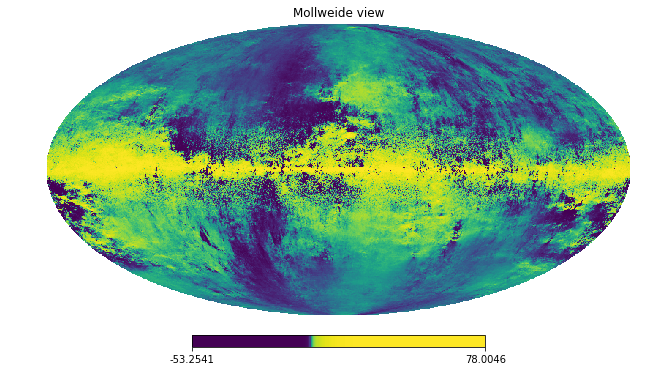

In [14]:
hp.mollview(dust_extra[1], norm = 'hist')

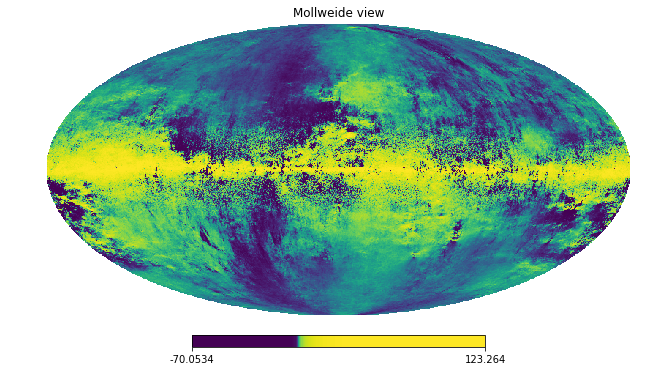

In [15]:
hp.mollview(dust_100[1], norm = 'hist')

In [16]:
# psm dust, uk_CMB, IQU
dust_psm_h = hp.read_map('/smc/jianyao/Ali_maps/thermaldust_map_95GHz.fits',field = None, h = True)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [17]:
dust_psm = hp.ud_grade(dust_psm_h[0], nside_out = 1024)

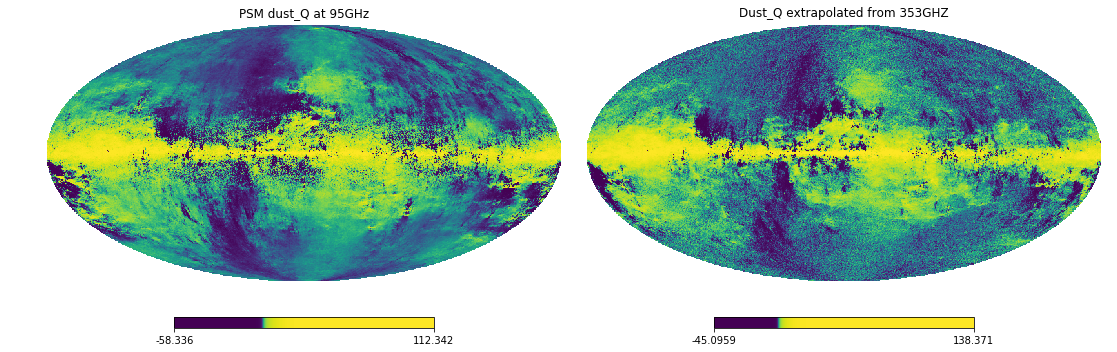

In [45]:
#95GHz . psm simulation, compared with extrapolation
plt.figure(figsize = (15, 10))
hp.mollview(dust_psm[1], norm = 'hist', sub = (1,2,1), title = 'PSM dust_Q at 95GHz')
hp.mollview(dust_extra_95[1], norm = 'hist', sub = (1, 2, 2), title = 'Dust_Q extrapolated from 353GHZ' )
plt.savefig('dust_maps_psm_Q.pdf', format = 'pdf')

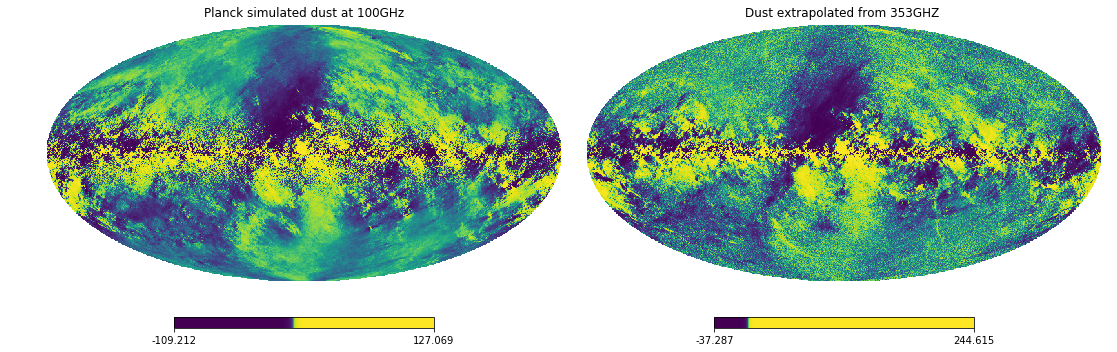

In [43]:
#100GHz . planck website simulation, compared with extrapolation
plt.figure(figsize = (15, 10))
mode = 2
hp.mollview(dust_100[mode], norm = 'hist', sub = (1,2,1), title = 'Planck simulated dust at 100GHz');
hp.mollview(dust_extra[mode], norm = 'hist', sub = (1,2,2), title = 'Dust extrapolated from 353GHZ ');
plt.savefig('dust_maps_planck.pdf', format = 'pdf');

In [176]:
np.linalg.norm(dust_100[1])

16695.28832405361

In [177]:
np.linalg.norm(dust_extra[1])

12611.48765864878

In [178]:
np.linalg.norm(dust_pysm[0][1])

15008.372537735582

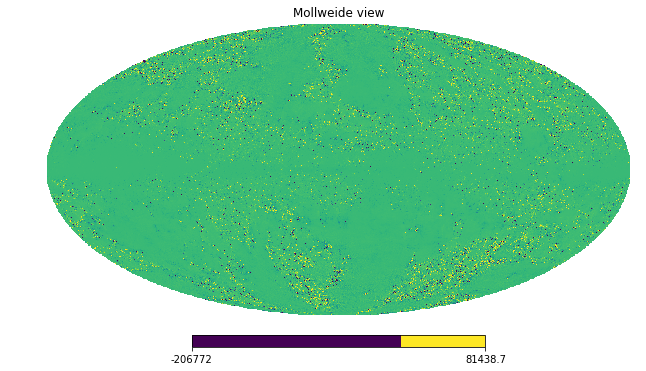

In [139]:
hp.mollview((dust_100[1] - dust_extra[1])/dust_100[1], norm = 'hist')

In [10]:
cmb_cl = hp.anafast(Mask(cmb), lmax = lmax)
n2cl = hp.anafast(noise_ali_ma, lmax = lmax)

In [50]:
L//Q

2

In [51]:
L = lmax; Q = int(L/2); Ell = np.ones(Q)
def bin_l(cl):
    bin_averages = []
#     for l in range(L):
#         cl[l] = l*(l+1)/2/np.pi*(cl[l])    
    for q in range(Q):
        bin_averages.append(sum(cl[q*L//Q:((q+1)*L//Q)]/(L//Q)))
    return bin_averages

for i in range(0,int(Q)):
    Ell[i] = (2*i+1)*L//Q/2 

In [28]:
cmb_bin = bin_l(cmb_cl[1])

In [71]:
n150cl = hp.anafast(noise_150, lmax = lmax)

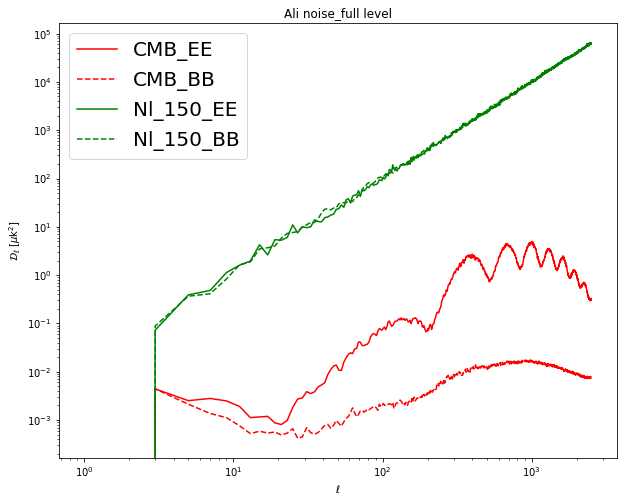

In [222]:
ell = np.arange(len(cmb_cl[0]))
plt.figure(figsize = (10,8))
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cl[1]),'r', label = 'CMB_EE')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cl[2]),'r--', label = 'CMB_BB')
# plt.loglog(ell, ell*(ell+1)/2/np.pi*cmb_cl[2],'r--', label = 'CMB_BB')

# plt.subplot(121)
# plt.plot(ell, ell*(ell+1)/2/np.pi*ncl1, 'b-x')
# # # plt.subplot(122)
# plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(n2cl[1]), 'k-', label = 'Nl_95_EE')
# plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(n2cl[2]), 'k--', label = 'Nl_95_BB')

plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(nls[1]), 'g', label = 'Nl_150_EE')
plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(nls[2]), 'g--', label = 'Nl_150_BB')

plt.xlabel('$\ell$'); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]')
plt.title('Ali noise_full level')
plt.legend(fontsize = 20)
plt.savefig('./ps_full_area_cmb_noise.pdf', format = 'pdf')

In [213]:
white_noise = hp.read_map('/smc/jianyao/Ali_maps/full_white_noise_realization_150.fits', field = None)
wn_ma = Mask(white_noise)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [214]:
noise_150_full = hp.read_map('/smc/jianyao/Ali_maps/full_noise_realizations_150.fits',field = None, verbose=False)
noise_150_full_ma = Mask(noise_150_full)

In [215]:
#signal plus white noise
swn = cmb + white_noise
#signal plus anisotropic noise
sn = cmb + noise_150_full_ma

cmb_ma = Mask(cmb) 
sn_ma = Mask(sn) ; swn_ma = Mask(swn)

In [216]:
cmb_cls = hp.anafast(cmb_ma, lmax = lmax, nspec = 3)
sn_cls = hp.anafast(sn_ma, lmax = lmax, nspec = 3); 
nls = hp.anafast(noise_150_full_ma, lmax = lmax, nspec = 3)
swn_cls = hp.anafast(swn_ma, lmax = lmax, nspec = 3)
wnls = hp.anafast(wn_ma, lmax = lmax, nspec = 3)

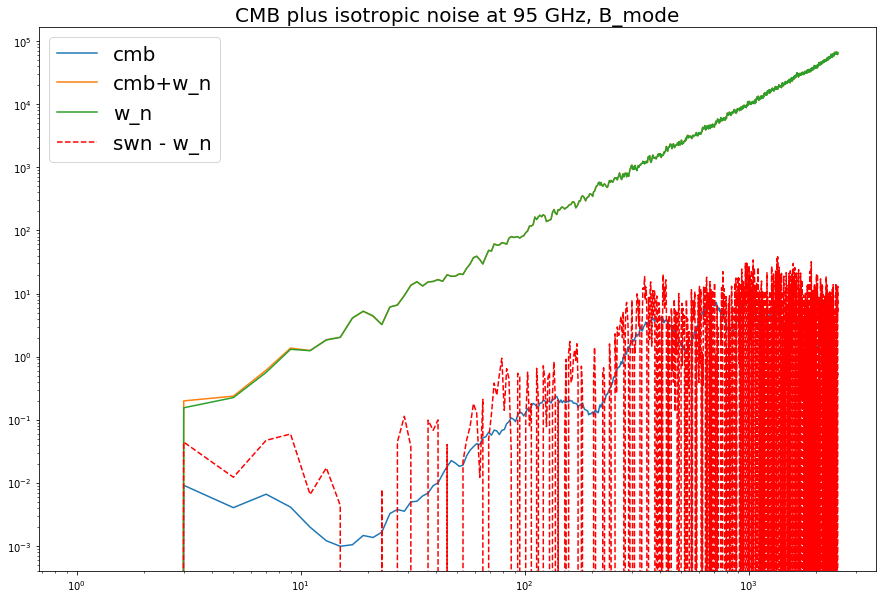

In [220]:
plt.figure(figsize = (15, 10)); S = 1
ell = np.arange(len(cmb_cls[0])); 
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cls[S]), label = 'cmb')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(swn_cls[S]), label = 'cmb+w_n')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(wnls[S]), label = 'w_n')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((swn_cls[S] - wnls[S])), 'r--',label = 'swn - w_n')
plt.title('CMB plus isotropic noise at 95 GHz, B_mode', fontsize = 20)
plt.legend(fontsize = 20)
# plt.savefig('./cmb_white_noise_95_GHz_B.pdf', format = 'pdf')

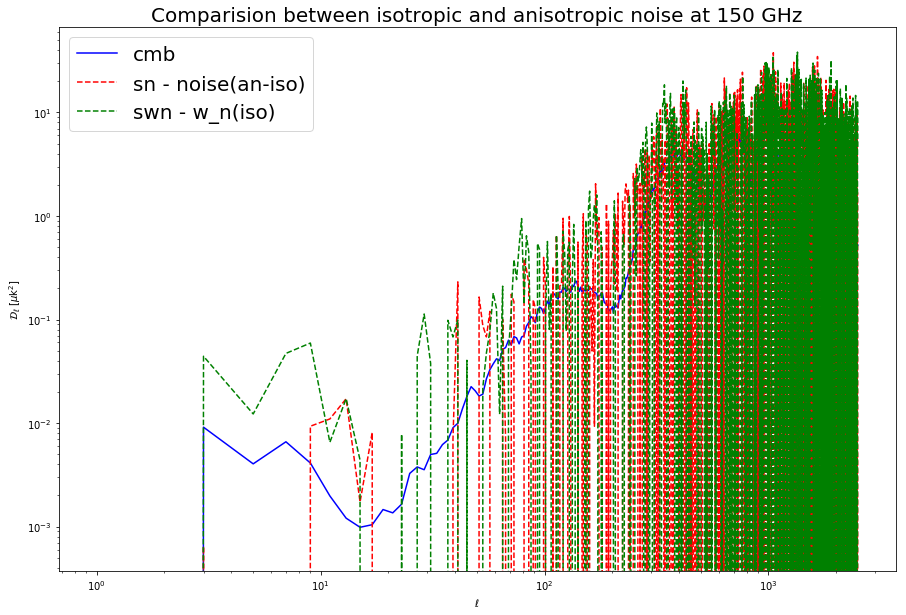

In [218]:
plt.figure(figsize = (15, 10)); S = 1
ell = np.arange(len(cmb_cls[0]))
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cls[S]), 'b-',label = 'cmb')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(sn_cls[S]), label = 'cmb+noise')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(nls[S]), label = 'noise')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((sn_cls[S] - nls[S])), 'r--',label = 'sn - noise(an-iso)')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((swn_cls[S] - wnls[S])), 'g--',label = 'swn - w_n(iso)')
plt.xlabel('$\ell$'); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]')
plt.title('Comparision between isotropic and anisotropic noise at 150 GHz', fontsize = 20)
plt.legend(fontsize = 20)
# plt.savefig('./comparision_B_mode_150GHz.pdf', format = 'pdf')

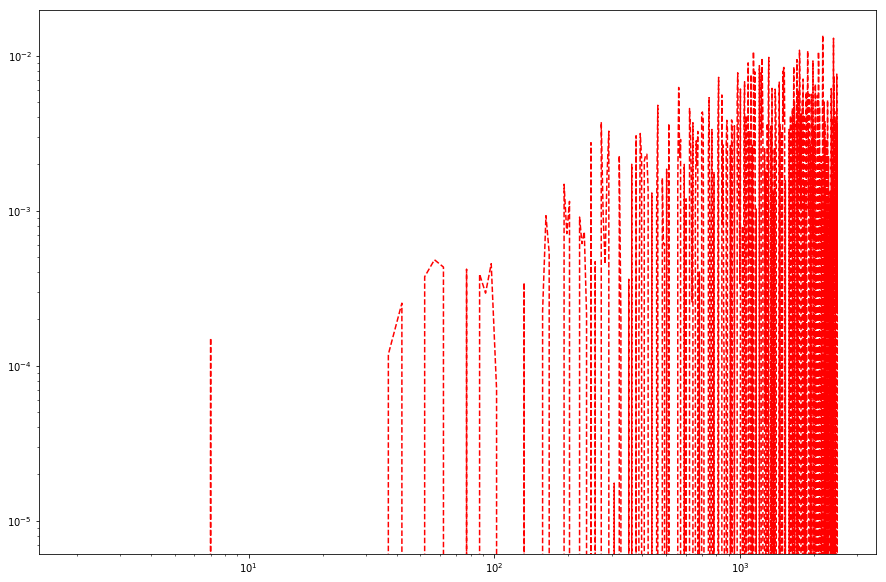

In [127]:
plt.figure(figsize = (15, 10));
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((swn_cls[S] - wnls[S]) - (sn_cls[S] - nls[S])), 'r--',label = 'swn - w_n')
plt.savefig('recovery_nosie_difference_95_Bmode.pdf', format = 'pdf')

# Dealing with foreground issue

In [13]:
# signal + foreground + noise
dust_ma = Mask(dust_100)
sfn = sn + dust_ma
dust_extra_ma = Mask(dust_extra)

In [72]:
# plt.figure(figsize = (30, 15))
# hp.mollview(dust_real[0],  norm = 'hist', title = 'Planck real dust by commander at 353GHz'); 
# hp.mollview(dust_100[1],  norm = 'hist', title = 'Planck simulated dust at 100GHz');
# hp.mollview(dust_extra[1], norm = 'hist', title = 'Dust at 100 GHz extrapolated from real dust')
# plt.savefig('dust.pdf', format = 'pdf')

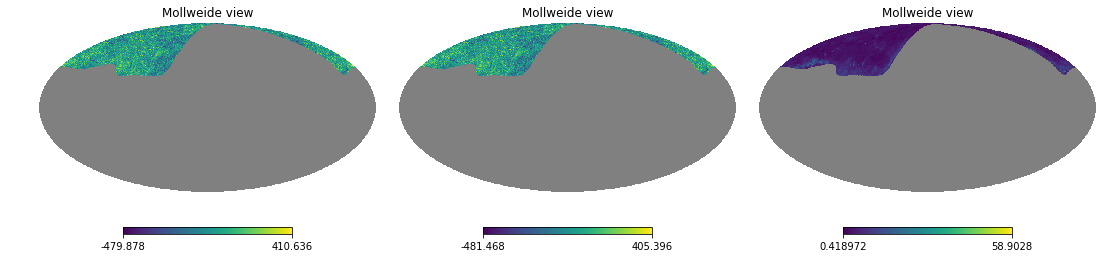

In [108]:
plt.figure(figsize = (15, 10))
hp.mollview(sfn[0], sub = (1,3,1)); hp.mollview(sn[0], sub = (1,3,2)); hp.mollview(dust_ma[0], sub = (1,3,3))

In [16]:
# sfn_cl = hp.anafast(sfn , lmax = lmax, nspec = 3)
sf_cls = hp.anafast(Mask(cmb + dust_100), lmax = lmax , nspec = 3)

In [17]:
# dust_extra_cl = hp.anafast(dust_extra_ma, lmax = lmax, nspec=3)

sn_exf = cmb + dust_100 - dust_extra
sn_exf_ma = Mask(sn_exf)
sn_exf_cl = hp.anafast(sn_exf_ma, lmax = lmax , nspec = 3)

In [18]:
cmb_ma = Mask(cmb) 
cmb_cls = hp.anafast(cmb_ma, lmax = lmax, nspec = 3)

Text(0.5, 1.0, 'Dust')

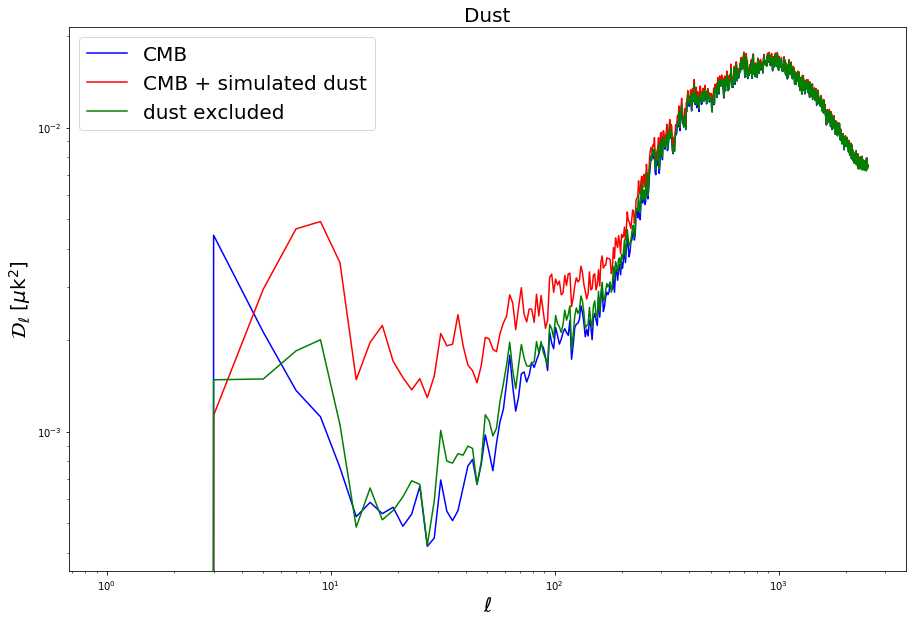

In [52]:
K = 2
ell = np.arange(len(cmb_cls[0])); #Ell = ell*(ell + 1)/2/np.pi
plt.figure(figsize = (15, 10))
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cls[K]), 'b',label = 'CMB')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(sf_cls[K]), 'r',label = 'CMB + simulated dust')

plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(sn_exf_cl[K]),'g', label = 'dust excluded')
plt.legend(fontsize = 20)

plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 20)
plt.title('Dust', fontsize = 20)
# plt.savefig('dust.pdf', format = 'pdf')

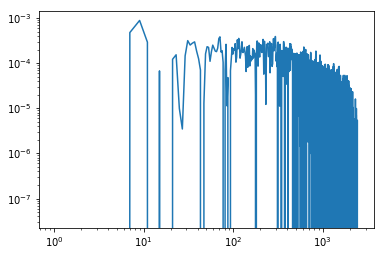

In [54]:
plt.loglog(Ell,  Ell*(Ell+1)/2/np.pi*bin_l(sn_exf_cl[K] - cmb_cls[K]))

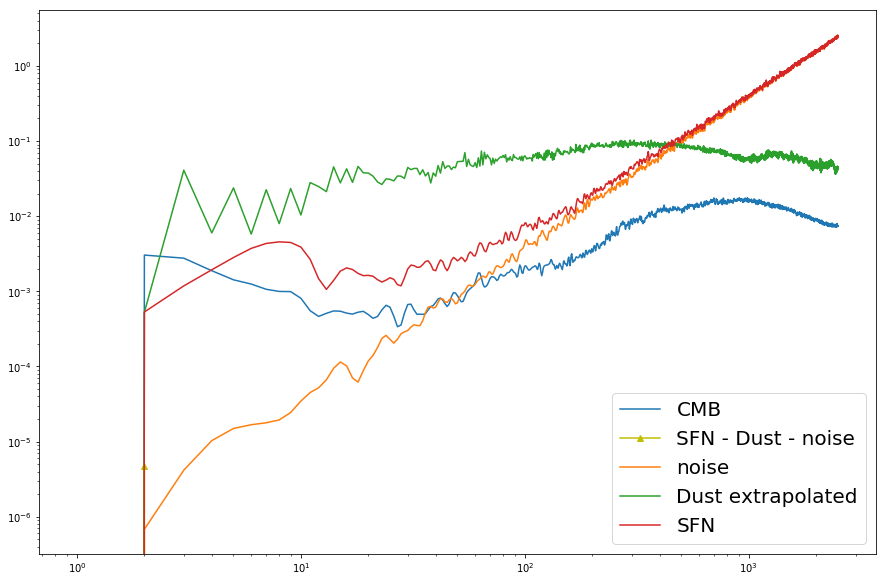

In [126]:
G = 2
plt.figure(figsize = (15, 10))
plt.loglog(ell, Ell*cmb_cl[G], label = 'CMB')
plt.loglog(ell, Ell*(sfn_cl[G] - dust_extra_cl[G] -nls[G]),'y-^', label = 'SFN - Dust - noise')

plt.loglog(ell, ell*(ell+1)/2/np.pi*nls[G], label = 'noise')

plt.plot(ell, Ell*dust_extra_cl[G], label = 'Dust extrapolated')
plt.loglog(ell, Ell*sfn_cl[G], label = 'SFN')
plt.legend(fontsize = 20)

# CAMB CMB cls

In [122]:
pars = camb.CAMBparams(); pars.WantTensors = True
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.26, ombh2=0.022, omch2=0.1199, mnu=0.06, omk=0, tau=0.078)
pars.InitPower.set_params(As=2.19856*1e-9, ns=0.9652, r=0.01)
pars.set_for_lmax(2500, lens_potential_accuracy=0);
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)

In [118]:
1.881*1e-9/np.e**(-2*0.078)

2.1985620880120438e-09

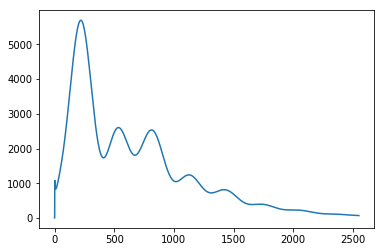

In [130]:
total = np.transpose(powers['total'])
lmax = 2550
ell = np.arange(lmax + 1)
plt.plot(ell, (ell*(ell+1))/2/np.pi*total[0])

In [136]:
cmb_maps = hp.synfast(total, nside = 1024, new = True)
hp.write_map('/smc/jianyao/Ali_maps/cmb_maps_camb.fits', cmb_maps)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


# pysm simulation 

In [169]:
# #

nu = np.array([100, 150, 353]);nside = 1024;
coefficients = convert_units("uK_RJ", "uK_CMB", nu)

def convert_unit(map):
    Nf = len(nu)
    for i in range(0,Nf):
        map[i] = map[i]*coefficients[i]
    return map

sky_config = {'dust':models('d1', nside)}
sky = pysm.Sky(sky_config)

dust_pysm = convert_unit(sky.signal()(nu))

# uK_CMB

15008.372537735582

# Ali noise and mask

In [11]:
# calculate the f_sky 
noise_ali = hp.read_map('/smc/jianyao/Ali_maps/noise_realizations1.fits', h = True)
n = (noise_ali[0]*0 + 1)
f_sky = len(n[n==1])/(12.0*nside**2)
# # nl_ful 

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [12]:
f_sky

1.0

In [46]:
### To generate the Ali_observational mask, and mask out the edge parts (I > 5 uK_CMB ) which have large errors.
n2test = hp.read_map('/smc/jianyao/Ali_maps/Noise_maps/fits/I_Noise_95_G_1024.fits', partial=True)
n2zeros = n2test*0
n2 = np.zeros_like(n2test);
index = np.arange(len(n2test))
n2[n2test <= 5] = 1
# ali_mask = hp.write_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits', n2)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/jianyao/anaconda2/lib/python2.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/jianyao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


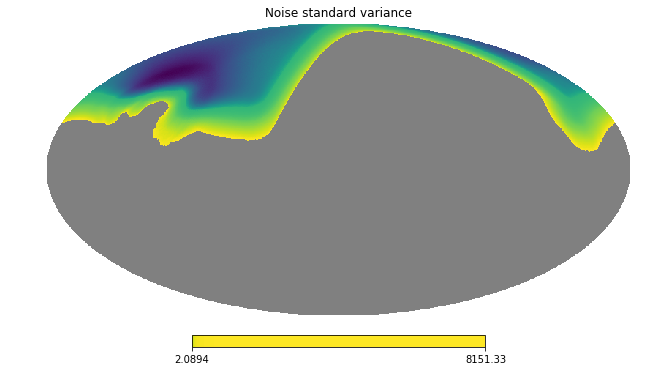

In [49]:
hp.mollview(n2test, norm = 'hist', title = 'Noise standard variance')
plt.savefig('Noise_standard_variance.pdf', format = 'pdf')

In [203]:
index[n2zeros == 0]

array([      0,       1,       2, ..., 5325081, 5325082, 5329178])

In [204]:
## To generate one realization of noise maps. 

n3test = hp.read_map('/smc/jianyao/Ali_maps/Noise_maps/fits/I_Noise_150_G_1024.fits', partial=True)
nIQU = np.zeros((3, len(n3test)))
index = np.arange(len(n2test))#index[n2test <= 5]
for i in index[n2zeros == 0]:
    nIQU[0][i] = np.random.normal(0, n3test[i])
    nIQU[1][i] = np.random.normal(0, n3test[i]*np.sqrt(2))
    nIQU[2][i] = np.random.normal(0, n3test[i]*np.sqrt(2))

hp.write_map('/smc/jianyao/Ali_maps/full_noise_realizations_150.fits', nIQU)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [209]:
noise_ali = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/full_noise_realizations_150.fits',field = None, verbose=False), nside_out = 1024)
noise_ali_ma = Mask(noise_ali)
f_sky = np.sum(ali_ma_full)/(12*nside**2) # f_sky = 0.1120
nl_full = hp.anafast(noise_ali_ma)/f_sky;
wn = hp.synfast(nl_full, nside = nside, new = True)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [210]:
hp.write_map('/smc/jianyao/Ali_maps/full_white_noise_realization_150.fits', wn)

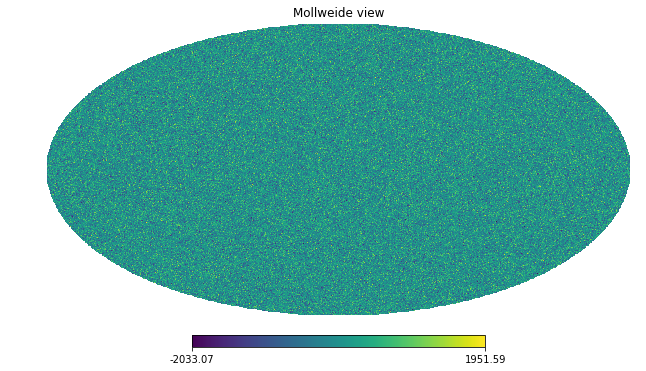

In [211]:
hp.mollview(wn[0])

In [212]:
f_sky

0.18222784996032715

In [3]:
dust_353 = hp.read_map('/smc/jianyao/Ali_maps/COM_SimMap_thermaldust-ffp10-skyinbands-353_2048_R3.00_full.fits', field = None, h = True)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [4]:
dust_100 = hp.read_map('/smc/jianyao/Ali_maps/COM_SimMap_thermaldust-ffp10-skyinbands-100_2048_R3.00_full.fits', field = None, h = True)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


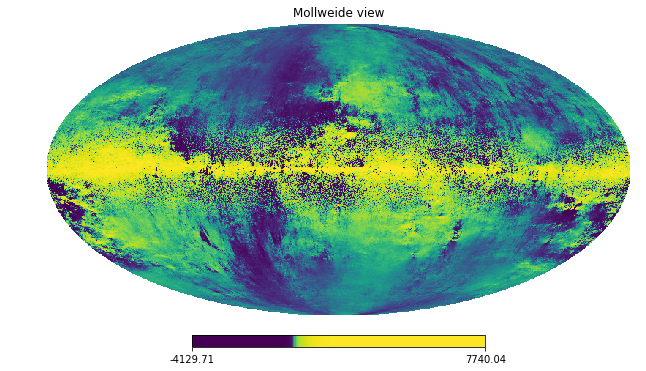

In [10]:
hp.mollview(dust_353[0][1]*1e6, norm = 'hist')

In [49]:
f3 = convert_units('uK_RJ', 'uK_CMB', 353)

In [50]:
f3

array(12.90551369)

In [11]:
planck_real = hp.read_map('/home/jianyao/Ali_maps/COM_CompMap_QU-thermaldust-commander_2048_R3.00_full.fits', verbose=False, field = None, h = True)

/home/jianyao/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


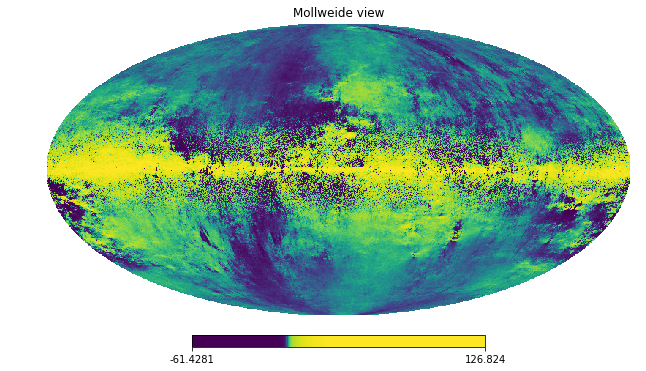

In [52]:
hp.mollview(dust_100[0][1]*1e6, norm = 'hist')

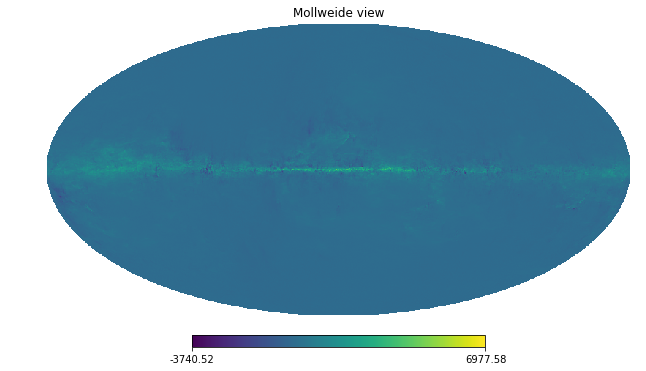

In [6]:
f = convert_units('uK_RJ', 'uK_CMB', 353)
hp.mollview(planck_real[0][0]*f)

In [19]:
dust_extra = np.zeros_like(planck_real[0])
# dust_extra Q map
dust_extra[1] = planck_real[0][0]*(100.0/353)**(planck_real[0][2])
#dust_extra U map 
dust_extra[2] = planck_real[0][1]*(100.0/353)**(planck_real[0][2])

In [25]:
f1 = convert_units('uK_RJ', 'uK_CMB', 100)

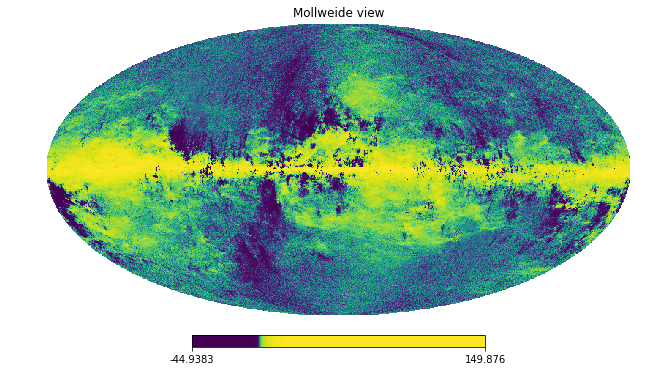

In [26]:
hp.mollview(dust_extra[1]*f1, norm = 'hist')

In [9]:
dust_100 = hp.read_map('/home/jianyao/Ali_maps/COM_SimMap_thermaldust-ffp10-skyinbands-100_2048_R3.00_full.fits', verbose=False, field = None, h = True)

In [42]:
print ()

i am $\ell$
